### Использование Линеаризации при подготовке выборок

In [1]:
import pandas as pd
import pandahouse as ph
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
from scipy import stats

import warnings
warnings.filterwarnings("ignore")

In [2]:
connection = {'host': 'https://clickhouse.lab.karpov.courses',
                      'database':'simulator_20230220',
                      'user':os.environ.get("DB_LOGIN"),
                      'password':os.environ.get("DB_PASS")
             }

In [3]:
query = '''
SELECT user_id, exp_group,
    sum(action = 'like') as likes,
    sum(action = 'view') as views,
    likes/views as ctr
FROM {db}.feed_actions 
WHERE toDate(time) between '2023-01-31' and '2023-02-06' 
AND exp_group in (0,1,2,3)
GROUP BY user_id, exp_group
'''

df = ph.read_clickhouse(query, connection=connection)

#### Группы 0 и 3. Сравнение результатов t-test на метриках CTR и Linearized likes 

In [4]:
# Сначала ttest на CTR без изменений

stats.ttest_ind(df[df.exp_group == 0].ctr, 
                df[df.exp_group == 3].ctr, 
                equal_var = False)


Ttest_indResult(statistic=-13.896870721904069, pvalue=1.055849414662529e-43)

In [5]:
# Общегрупповой CTR (Контрольная группа 0)
ctr_control = df[df.exp_group == 0].likes.sum() / df[df.exp_group == 0].views.sum()


# Линеаризованные лайки
df['linearized_likes_03'] = df.likes - ctr_control * df.views


# T-test на линеаризованных лайках 
stats.ttest_ind(df[df.exp_group == 0].linearized_likes_03, 
                df[df.exp_group == 3].linearized_likes_03, 
                equal_var=False)


Ttest_indResult(statistic=-15.214995460903827, pvalue=5.4914249479690016e-52)

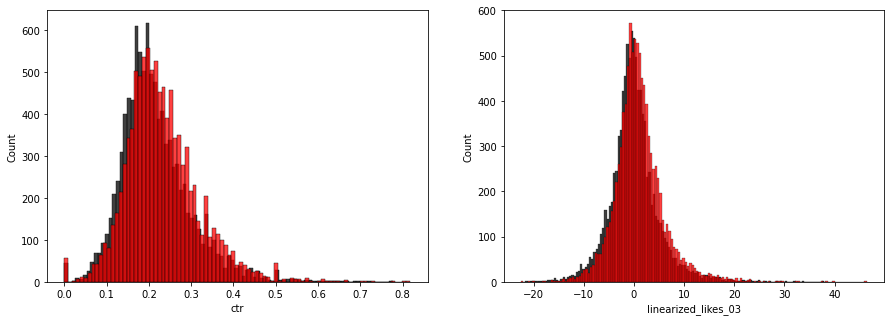

In [6]:
plt.figure(figsize= (15, 5))

plt.subplot(1,2,1)
sns.histplot(df[df.exp_group == 0].ctr, color = 'black')
sns.histplot(df[df.exp_group == 3].ctr, color = 'red')

plt.subplot(1,2,2)
sns.histplot(df[df.exp_group == 0].linearized_likes_03, color = 'black')
sns.histplot(df[df.exp_group == 3].linearized_likes_03, color = 'red');

__Вывод по тесту на группах 0 и 3.__ </BR></BR>
T-Тест на метрике linearized_likes показывает лучшую чувствительность. </br>
p-value на этой метрике в 5 * 10^9 раз меньше, чем на CTR.

#### Группы 1 и 2. Сравнение результатов t-test на метриках CTR и Linearized likes 

In [7]:
# Сначала тесты на CTR без изменений

# Требование к распределению для проведения ttest не соблюдено, 
# однако интересно, как линеаризация скажется на результатах 
print (stats.ttest_ind(df[df.exp_group == 1].ctr, 
                       df[df.exp_group == 2].ctr, 
                       equal_var = False))

print (stats.mannwhitneyu(df[df.exp_group == 1].ctr, 
                          df[df.exp_group == 2].ctr))

Ttest_indResult(statistic=0.7094392041270485, pvalue=0.4780623130874935)
MannwhitneyuResult(statistic=56601260.5, pvalue=6.0376484617779035e-56)


In [8]:
# Общегрупповой CTR (Контрольная группа 1)
ctr_control = df[df.exp_group == 1].likes.sum() / df[df.exp_group == 1].views.sum()


# Линеаризованные лайки
df['linearized_likes_12'] = df.likes - ctr_control * df.views


# T-test на линеаризованных лайках 
stats.ttest_ind(df[df.exp_group == 1].linearized_likes_12, 
                df[df.exp_group == 2].linearized_likes_12, 
                equal_var=False)

print (stats.ttest_ind(df[df.exp_group == 1].linearized_likes_12, 
                       df[df.exp_group == 2].linearized_likes_12, 
                       equal_var = False))

print (stats.mannwhitneyu(df[df.exp_group == 1].linearized_likes_12, 
                          df[df.exp_group == 2].linearized_likes_12))


Ttest_indResult(statistic=6.122579994775974, pvalue=9.439432187037644e-10)
MannwhitneyuResult(statistic=54534537.0, pvalue=9.404319579641738e-27)


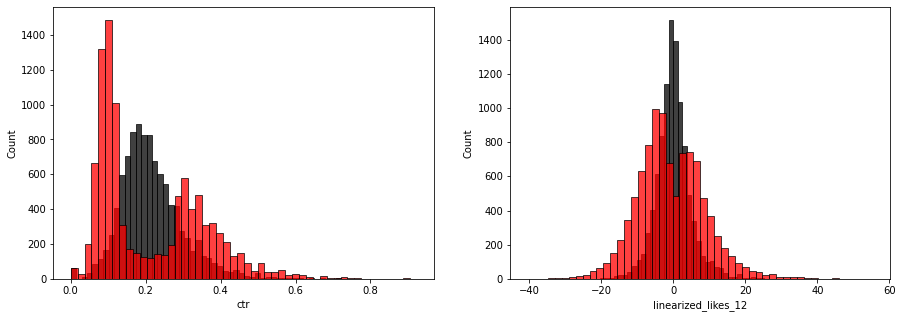

In [9]:
# Для наглядности построю графики распределений CTR и Lin_likes

plt.figure(figsize= (15, 5))

plt.subplot(1,2,1)
sns.histplot(df[df.exp_group == 1].ctr, color = 'black', bins=50 )
sns.histplot(df[df.exp_group == 2].ctr, color = 'red', bins=50)

plt.subplot(1,2,2)
sns.histplot(df[df.exp_group == 1].linearized_likes_12, color = 'black', bins=50)
sns.histplot(df[df.exp_group == 2].linearized_likes_12, color = 'red', bins=50);

__Вывод по тесту на группах 1 и 2.__ </BR></BR>

T-Тест на метрике linearized_likes показывает лучшую чувствительность. </br>
Однако, в данном примере, правильнее смотреть на pvalue теста Манна -Уитни. И он показал меньшую чувствительность
